In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Download macro data (CPI)

import pandas_datareader.data as pdr
import datetime

start = datetime.datetime(1990,1,1)
end   = datetime.datetime.today()

cpi = pdr.DataReader("CPIAUCSL", "fred", start, end)
cpi = cpi.dropna()

# Calculate inflation rate as log returns of CPI
inflation = np.log(cpi).diff().dropna()


In [3]:
# Unit-root test via augmented Dickey–Fuller (ADF) test

from statsmodels.tsa.stattools import adfuller

adf = adfuller(np.log(cpi))
print("--- ADF unit-root test of logged monthly CPI ---")
print(f"ADF statistic: {adf[0]:.2f}, p-value: {adf[1]:.6f}")
if adf[1] < 0.05:
    print(">> Null hypothesis rejected")
else:
    print(">> The unit-root hypothesis cannot be rejected")
    # Test the first differencing series
    adf_diff = adfuller(inflation)
    print("\n--- ADF unit-root test of monthly inflation rate ---")
    print(f"ADF statistic: {adf_diff[0]:.2f}, p-value: {adf_diff[1]:.6f}")
    if adf_diff[1] < 0.05:
        print(">> Null hypothesis rejected")
    else:
        print(">> The unit-root hypothesis cannot be rejected")

--- ADF unit-root test of logged monthly CPI ---
ADF statistic: 0.30, p-value: 0.977272
>> The unit-root hypothesis cannot be rejected

--- ADF unit-root test of monthly inflation rate ---
ADF statistic: -4.00, p-value: 0.001417
>> Null hypothesis rejected


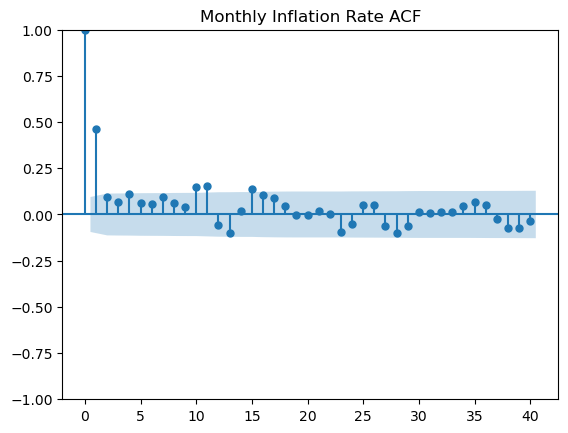

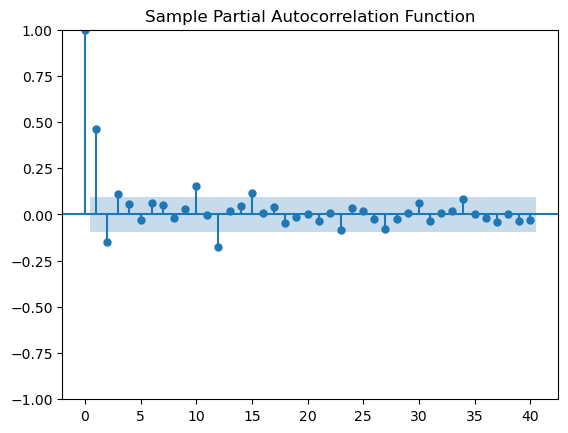

In [4]:
# Order determination via ACF & PACF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF is useful in identifying the order of a moving-average (MA) model as ACF cuts off at lag q for an MA(q) series.
plot_acf(inflation, lags=40, alpha=0.05)
plt.title("Monthly Inflation Rate ACF")

# Partial autocorrelation is a tool for identifying the order of an autoregressive (AR) model.
# The model is based on multiple linear regression and estimated by the least-squares method and the partial F test.
plot_pacf(inflation, lags=40, alpha=0.05)
plt.title("Sample Partial Autocorrelation Function")
plt.show()


In [5]:
# The second approach to order specification uses information criteria AIC/BIC. 
# AIC provides a single, quantifiable metric that considers both the number of lags and the model's fit; BIC tends to select a lower AR model when the sample size is moderate or large. 

import pmdarima as pm
# Auto ARIMA
model = pm.auto_arima(inflation, 
                      seasonal=False,
                      stepwise=True, # if True will do stepwise selection (faster); otherwise, it searches over all models
                      information_criterion="aic", # information criterion used to select the best ARIMA model (‘aic’, ‘bic’, ‘hqic’, ‘oob’)
                      trace=True) # print status on the fits

# We are looking for a model ARIMA(p,d,q), where 
# p (AR) is the number of lag observations included in the model, 
# d (I) the number of times the raw observations are differenced to make the time series stationary, and
# q (MA) the size of the moving average window. 

model.summary() 
# The table lists the estimated coefficients and their standard errors and p-values (P>|z|) for the parameters of the model. 
# Ljung-Box Q (Prob(Q)) is a test for autocorrelation in the residuals (the errors). A high p-value suggests the residuals are independent and randomly distributed ("white noise"), which is a desirable outcome. A low p-value indicates that there is still information in the residuals that the model failed to capture.
# Jarque-Bera (Prob(JB)) tests for the normality of the residuals.
# Heteroskedasticity (Prob(H)) tests if the residuals have constant variance over time. A high p-value is preferred, indicating constant variance (homoskedasticity).


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-3952.569, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3642.765, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3902.667, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3828.138, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-3949.740, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-3901.202, Time=0.74 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-3947.234, Time=0.36 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-3960.966, Time=0.30 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-3963.295, Time=0.22 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-3870.435, Time=0.29 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-3959.568, Time=0.29 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-3871.301, Time=0.33 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-3882.015, Time=0.64 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-3958.623, Time=1.24 sec
 ARIMA(1,0,3)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  429
Model:               SARIMAX(0, 0, 2)   Log Likelihood                1989.271
Date:                Tue, 06 Jan 2026   AIC                          -3970.542
Time:                        20:57:18   BIC                          -3954.297
Sample:                             0   HQIC                         -3964.127
                                - 429                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.000     11.042      0.000       0.002       0.003
ma.L1          0.5508      0.029     18.779      0.000       0.493       0.608
ma.L2          0.1095      0.041      2.664      0.008       0.029       0.190
sigma2      5.467e-06   2.19e-07     25.016      0.000    5.04e-06    5.89e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               535.58
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
# Fit ARIMA (find optimal parameters)

from statsmodels.tsa.arima.model import ARIMA

p, d, q = model.order

arima = ARIMA(inflation, order=(p,d,q))
fit = arima.fit()

print(fit.summary())


C:\Users\WZ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\WZ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\WZ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               CPIAUCSL   No. Observations:                  429
Model:                 ARIMA(0, 0, 2)   Log Likelihood                1989.246
Date:                Tue, 06 Jan 2026   AIC                          -3970.491
Time:                        20:57:23   BIC                          -3954.245
Sample:                             0   HQIC                         -3964.076
                                - 429                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000     11.136      0.000       0.002       0.003
ma.L1          0.5441      0.029     18.461      0.000       0.486       0.602
ma.L2          0.0989      0.041      2.392      0.0

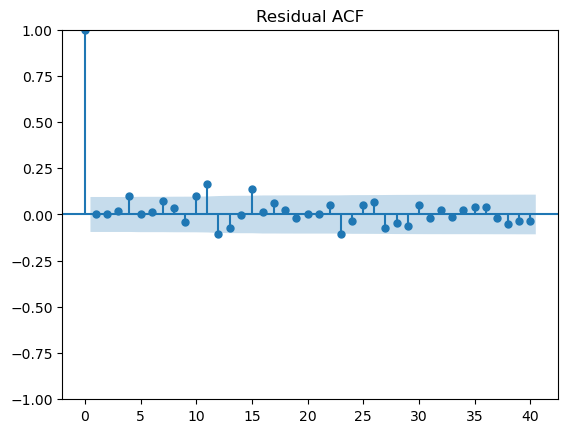

,lb_stat,lb_pvalue
10,13.038091,0.22155


In [7]:
# Residual diagnostics (a good model has residuals essentially white noise and Ljung-Box insignificant)

res = fit.resid

plot_acf(res, lags=40)
plt.title("Residual ACF")
plt.show()

# Ljung–Box test of residual autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(res, lags=[10], return_df=True)


In [8]:
# Rolling estimation to check for parameter instability
# This is done by repeatedly estimating a model on moving subsets (windows) of data, revealing how coefficients change over time. 

from statsmodels.tsa.arima.model import ARIMA

window = 120 # 10 years of monthly data
params = []

for i in range(window, len(inflation)):
    sub = inflation.iloc[i-window: i].asfreq('MS') 
    m = ARIMA(sub, order=(p,d,q)).fit() 
    params.append(m.params) # fitted model parameters


C:\Users\WZ\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\WZ\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\WZ\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\WZ\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\WZ\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood op

⚠️ The above convergence warning indicates that the algorithm (the maximum likelihood estimation) used to find the best fit for the model gave up before it finished; it cannot find a stable parameter vector that maximizes the likelihood. This possibly happen when (1) the process is near a random walk; (2) characteristic roots are near unit in modulus (non-stationarity); (3) parameters shift over time (exactly what we are trying to check); (4) the window is too short; (5) the data is low signal-to-noise. 

This indicates structural instability: as each rolling window has different volatility, autocorrelation and structural breaks, the same ARIMA(p,d,q) may be well-defined or ill-defined in different periods.

The warning is actually evidence of the  phenomena that the parameters of ARIMA models are not stable across regimes (e.g., from a period of economic boom to a recession) and that the long-term predictability is weak. 

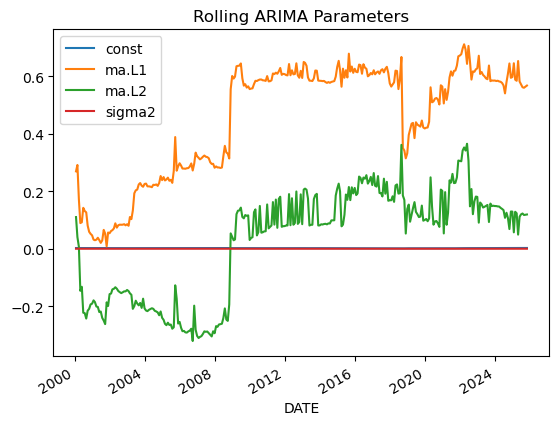

In [9]:
params = pd.DataFrame(params, index=inflation.index[window:])
params.plot(title = "Rolling ARIMA Parameters")
plt.show()


In [10]:
# Out-of-sample forecasting

train = inflation[:-24]
test  = inflation[-24:]

model = ARIMA(train.asfreq('MS'), order=(p,d,q)).fit()
forecast = model.forecast(steps=24) # forecast the next 24 steps


In [11]:
# RMSE comparison of the forecast of an ARIMA model vs a random walk model

# ARIMA
rmse_arima = np.sqrt(np.mean((forecast-test.iloc[:, 0])**2))

# A random walk with drift is a model ARIMA(0,1,0)
rw_model = ARIMA(train.asfreq('MS'), order=(0,1,0), trend="t").fit()
#print(rw_model.mle_retvals)
rw_forecast = rw_model.forecast(steps=24)
rmse_rw = np.sqrt(np.mean((rw_forecast - test.iloc[:, 0])**2))

print(f"ARIMA RMSE: {rmse_arima:.6f}")
print(f"RW RMSE: {rmse_rw:.6f}")
# The Root Mean Square Error measures the average magnitude of errors between predicted values and actual observed values. 


ARIMA RMSE: 0.001279
RW RMSE: 0.002010


C:\Users\WZ\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
